# Сегментация соска молочной железы на маммограмме.

Рак молочной железы является [наиболее распространенным](https://www.who.int/ru/news-room/fact-sheets/detail/breast-cancer) видом рака: в 2020 г. было зарегистрировано свыше 2,2 миллиона случаев этого заболевания.
В течение своей жизни раком молочной железы будет болеть примерно каждая двенадцатая женщина. Рак молочной железы является главной причиной смерти женщин от онкологических заболеваний. В 2020 г. примерно 685 000 женщин умерли от этой болезни.

Один из способов, помогающих диагностировать данное заболевание - Рентгеновская маммография. Для обнаружения раковой опухли на рентгене можно использовать машинное обучение в качестве помощи врачам. Идея в том, чтобы модель машинного обучения определяла качество \([PGMI](https://radiographia.info/article/pgmi-standartnye-kriterii-kachestva-mammografii
)\) только что созданной маммограммы, чтобы на месте понять, нужно ли переделывать снимок.

Один из критериев PGMI - видимость соска.

В этом ноутбуке решается задача сегментации соска молочной железы на изображении. 

## Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Создадим папки для тренировочных и тестовых картинок
os.mkdir('test')
os.mkdir('train')
os.mkdir('input')

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split

# Форма изображений, с которой будем работать
INPUT_SHAPE = 224, 224

drive_path = 'drive/MyDrive/Breast/NippleSegmentation/'
nipples_paths = list(Path(drive_path).glob('*mask.png'))

y_drive_train, y_drive_test = train_test_split(nipples_paths)

X_drive_paths = list(Path(drive_path + '/input').glob('*'))
X_drive_train, X_drive_test = train_test_split(X_drive_paths)

In [4]:
import shutil
from tqdm import tqdm

new_path = 'train/'
for path in tqdm(y_drive_train):
    shutil.copy(path, new_path + path.name)

new_path = 'test/'
for path in tqdm(y_drive_test):
    shutil.copy(path, new_path + path.name)

100%|██████████| 67/67 [00:00<00:00, 675.16it/s]


In [5]:
train_paths = list(Path('train/').glob("*"))
test_paths = list(Path('test/').glob("*"))

print('Тренировочных картинок: {} \nТестовых картинок: {}'.format(len(train_paths), len(test_paths)))

Тренировочных картинок: 199 
Тестовых картинок: 67


Объем датасета не большой. Поэтому поместим его в оперативную память, чтобы не тратить время на подгрузку картинок в процессе обучения.

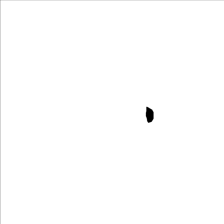

In [6]:
from PIL import Image

# Пример картинки
Image.open(train_paths[0]).resize((224, 224))

In [7]:
import numpy as np
from PIL import Image

# Подготовим маски изображений для обучения
def get_mask(paths):
    masks = []
    for path in paths:
        im = Image.open(path)
        im = im.resize(INPUT_SHAPE)
        im_array = np.asarray(im)
        im_array = 255 - im_array
        im_array = (im_array > 150).astype(np.float32)

        # Пара картинок получаются некорректными (маска белая, фон черный). Исправим
        if im_array.mean() > 0.1:
            im_array = np.abs(im_array - 1)

        im_array = im_array.reshape(-1)

        masks.append(im_array)
    return np.array(masks)

y_train = get_mask(train_paths)
y_test = get_mask(test_paths)

In [8]:
drive_input = list(Path(drive_path + '/input').glob('*'))

# Подготовим входные данные для обучения
def get_inputs(paths):
    inputs = []
    for path in tqdm(paths):
        num = path.stem.replace('.png_mask', '')
        path = drive_path + '/input/' + num + '.png'
        im = Image.open(path)
        im = im.resize(INPUT_SHAPE)
        im = np.asarray(im).astype(np.float32)
        inputs.append(im)
    return np.array(inputs)

X_train = get_inputs(train_paths)
X_test = get_inputs(test_paths)

100%|██████████| 67/67 [00:01<00:00, 56.52it/s]


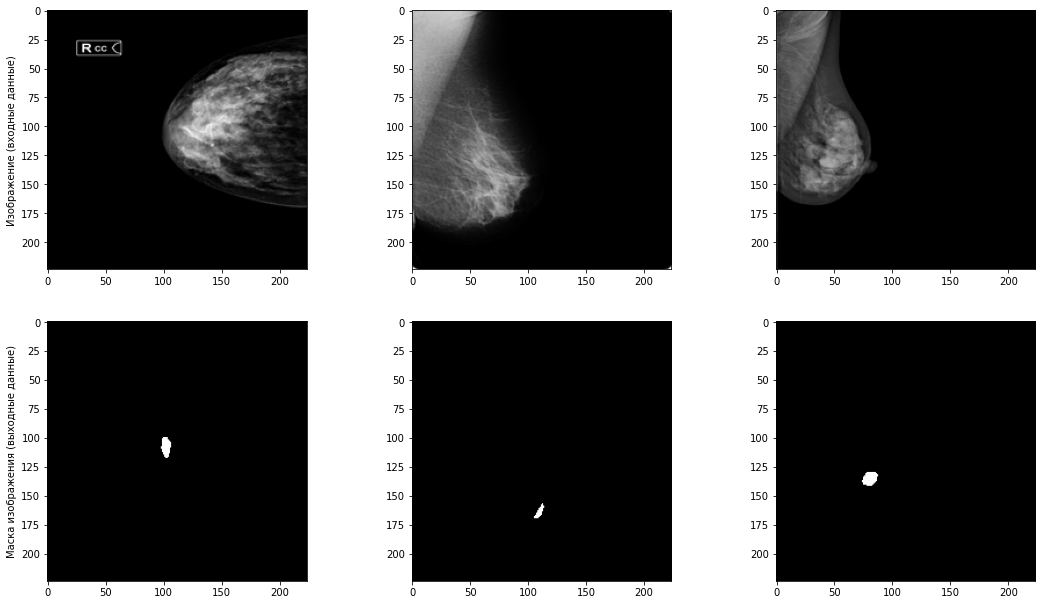

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(18.5, 10.5)
for ax_orig, ax_mask in axes.T:
    k = np.random.choice(len(y_train))
    ax_orig.imshow(X_train[k], cmap='gray')
    ax_mask.imshow(y_train[k].reshape(INPUT_SHAPE), cmap='gray')

axes[0, 0].set_ylabel('Изображение (входные данные)')
_ = axes[1, 0].set_ylabel('Маска изображения (выходные данные)')

## Loss-функция Dice

При обучении мы считаем черный пиксель относящимся к классу 0, белый - к классу 1. 

In [10]:
# Среднее число класса 1
y_train.mean()

0.0012254352

Как видно, мы имеем дело с сильным дисбалансом классов (классов 1 в ~$10^3$ раз меньше). В таком случае в качестве метрики для измерения ошибки модели должен подойти инвертированный [индекс Соренсена-Дайса](https://arxiv.org/pdf/1606.04797v1.pdf) \(или [расстояние Жаккара](https://ru.frwiki.wiki/wiki/Indice_et_distance_de_Jaccard)): 
$$loss(X, Y) = 1 - 2 \cdot \frac{|X \cap Y|}{|X \cup Y|},$$
где $X, Y$ - это предсказание модели и целевое значение соответственно.

In [11]:
from keras import backend as K

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

## Модель

Построим архитектуру по типу UNet. Используем батч-нормализацию и relu после каждого слоя свертки. Так же добавим 3 слоя пространственного dropout от переобучения. Для учета того, что нужный нам объект (сосок) на картинке довольно мелких размеров, используем `dilation_rate=2` в некоторых свертках. 

In [12]:
from keras.layers import Input, Concatenate, Conv2D, Activation, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, SpatialDropout2D
from keras import Model

def create_model(input_shape = (*INPUT_SHAPE, 1)):
    inp = Input(shape=input_shape)

    conv_1_1 = Conv2D(32, (3, 3), padding='same', dilation_rate=2)(inp)
    conv_1_1 = BatchNormalization()(conv_1_1)
    conv_1_1 = Activation('relu')(conv_1_1)
    pool_1 = MaxPooling2D(2)(conv_1_1)

    conv_1_2 = Conv2D(64, (3, 3), padding='same', dilation_rate=2)(pool_1)
    conv_1_2 = BatchNormalization()(conv_1_2)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_2 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_2_1 = BatchNormalization()(conv_2_1)
    conv_2_1 = SpatialDropout2D(0.2)(conv_2_1)
    conv_2_1 = Activation('relu')(conv_2_1)

    up_1 = UpSampling2D(2, interpolation='bilinear')(conv_2_1)
    conc_1 = Concatenate()([conv_1_2, up_1])

    conv_2_2 = Conv2D(64, (3, 3), padding='same', dilation_rate=2)(conc_1)
    conv_2_2 = BatchNormalization()(conv_2_2)
    conv_2_2 = Activation('relu')(conv_2_2)
    conv_2_2 = SpatialDropout2D(0.2)(conv_2_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_2_2)
    conc_2 = Concatenate()([conv_1_1, up_2])

    conv_up_4_1 = Conv2D(32, (3, 3), padding='same', dilation_rate=2)(conc_2)
    conv_up_4_1 = BatchNormalization()(conv_up_4_1)
    conv_up_4_1 = Activation('relu')(conv_up_4_1)
    conv_up_4_1 = SpatialDropout2D(0.2)(conv_up_4_1)

    conv_up_4_2 = Conv2D(1, (3, 3), padding='same', dilation_rate=2)(conv_up_4_1)
    conv_up_4_2 = BatchNormalization()(conv_up_4_2)

    result = Activation('sigmoid')(conv_up_4_2)
    result = Flatten()(result)

    return Model(inputs=inp, outputs=result)

model_1 = create_model()

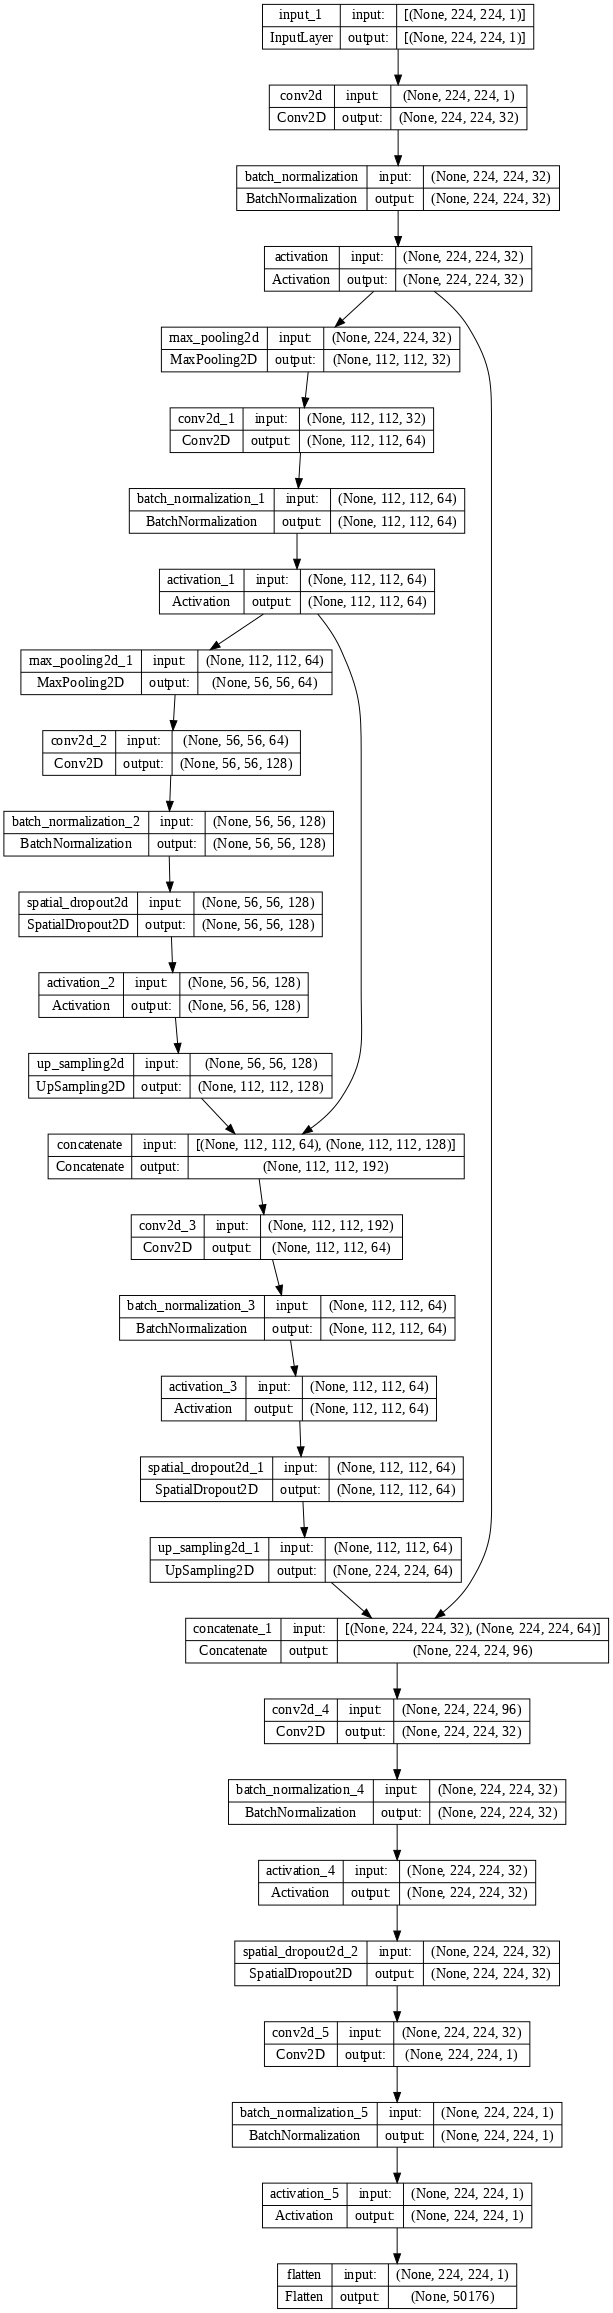

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model_1, show_shapes=True, dpi=70,)

## Обучение модели

### Обучение с Dice

В качестве лосс-функции будет ранее написанный нами индекс Дайса. В качестве оптимизатора выберем Adam. Он хорошо работает против локальных минимумов. Метрик будет две: Recall, Precision. 

In [14]:
import keras
from tensorflow.keras.metrics import Recall, Precision

adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99,
                             epsilon=1e-08, decay=0.0)
model_1.compile(adam, DiceLoss, metrics=[Recall(name='recall'), 
                                         Precision(name='precision'),
                                         ], 
                loss_weights=[1000, 1],)

In [15]:
history = model_1.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 18s 183ms/step - loss: 995.5770 - recall: 0.9523 - precision: 0.0040 - val_loss: 995.3909 - val_recall: 0.9842 - val_precision: 0.0082
Epoch 2/100
25/25 [==============================] - 3s 115ms/step - loss: 994.9898 - recall: 0.9999 - precision: 0.0049 - val_loss: 993.6483 - val_recall: 0.9489 - val_precision: 0.0167
Epoch 3/100
25/25 [==============================] - 3s 116ms/step - loss: 994.8781 - recall: 0.9998 - precision: 0.0055 - val_loss: 993.6921 - val_recall: 0.9918 - val_precision: 0.0148
Epoch 4/100
25/25 [==============================] - 3s 123ms/step - loss: 994.8071 - recall: 1.0000 - precision: 0.0062 - val_loss: 993.5759 - val_recall: 0.9962 - val_precision: 0.0134
Epoch 5/100
25/25 [==============================] - 3s 124ms/step - loss: 994.7469 - recall: 1.0000 - precision: 0.0061 - val_loss: 993.5955 - val_recall: 0.9998 - val_precision: 0.0120
Epoch 6/100
25/25 [==============================] - 3s 124ms/st

#### Результат обучения

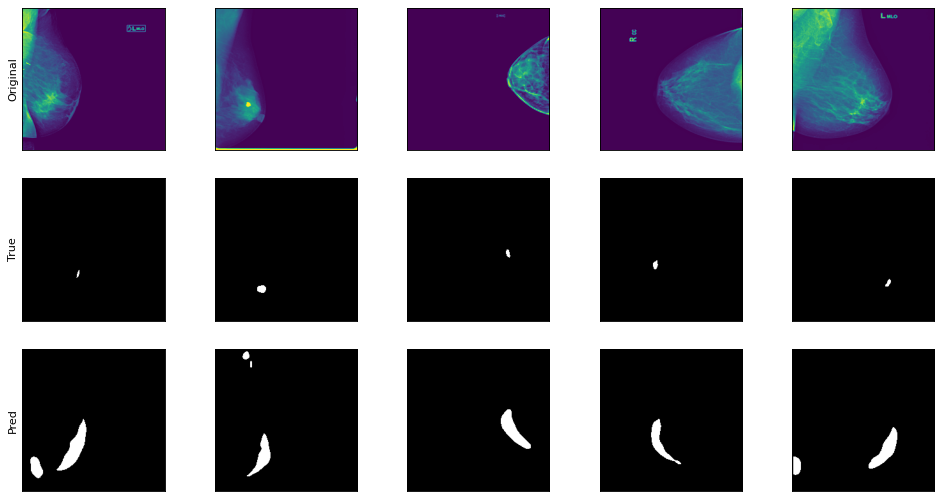

In [16]:
import matplotlib.pyplot as plt

def show_results(net, X, y, cols = 5):
    rand_idxs = np.random.randint(0, len(y), size=cols)
    plt.figure(figsize=(15, 8), dpi=80)
    preds = net(X[rand_idxs])

    for col in range(1, cols+1):
        ax = plt.subplot(3, cols, col, xticks=[], yticks=[])
        if col == 1:
            ax.set_ylabel('Original')
        ax.imshow(X[rand_idxs[col-1]])

    for col in range(1, cols+1):
        ax = plt.subplot(3, cols, col + cols, xticks=[], yticks=[])
        if col == 1:
            ax.set_ylabel('True')
        ax.imshow(y[rand_idxs[col-1]].reshape(INPUT_SHAPE), cmap='gray', )

    for col in range(1, cols+1):
        ax = plt.subplot(3, cols, col + 2*cols, xticks=[], yticks=[])
        if col == 1:
            ax.set_ylabel('Pred')
        ax.imshow(np.reshape(preds[col-1], INPUT_SHAPE)[:, :] > 0.5, cmap='gray')

    plt.show()

show_results(model_1, X_test, y_test)

In [17]:
for key in history.history.keys():
    print(key + ':', history.history[key][-1])

loss: 986.948974609375
recall: 1.0
precision: 0.03641417250037193
val_loss: 985.1201171875
val_recall: 0.9326009154319763
val_precision: 0.04557798430323601


Как видим, результат получился не лучший. Получился очень низкий precision. То есть модель классифицирует слишком много ложных классов 1. Попробуем поменять гиперпараметры.

### Обучение с BCE

Возьмем ту же модель, но изменим лосс-функцию на бинарную кросс-энтропию и  перевес класса в лосс функции с 1000 на 200.

In [18]:
model_2 = create_model()
adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99,
                             epsilon=1e-08, decay=0.0)
model_2.compile(adam, 'binary_crossentropy', 
                metrics=[Recall(name='recall'),
                         Precision(name='precision'),],
                loss_weights=[200, 1],)

In [19]:
history = model_2.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 5s 140ms/step - loss: 148.9937 - recall: 0.6600 - precision: 0.0011 - val_loss: 123.3419 - val_recall: 0.5428 - val_precision: 0.0026
Epoch 2/100
25/25 [==============================] - 3s 120ms/step - loss: 143.4968 - recall: 0.8203 - precision: 0.0016 - val_loss: 113.6798 - val_recall: 0.6486 - val_precision: 0.0039
Epoch 3/100
25/25 [==============================] - 3s 122ms/step - loss: 141.1886 - recall: 0.7939 - precision: 0.0015 - val_loss: 97.7523 - val_recall: 0.5075 - val_precision: 0.0028
Epoch 4/100
25/25 [==============================] - 3s 119ms/step - loss: 139.1473 - recall: 0.7526 - precision: 0.0017 - val_loss: 129.8342 - val_recall: 0.6060 - val_precision: 0.0028
Epoch 5/100
25/25 [==============================] - 3s 120ms/step - loss: 136.9521 - recall: 0.6845 - precision: 0.0019 - val_loss: 136.3345 - val_recall: 0.5096 - val_precision: 0.0027
Epoch 6/100
25/25 [==============================] - 3s 121ms/step

#### Результат обучения

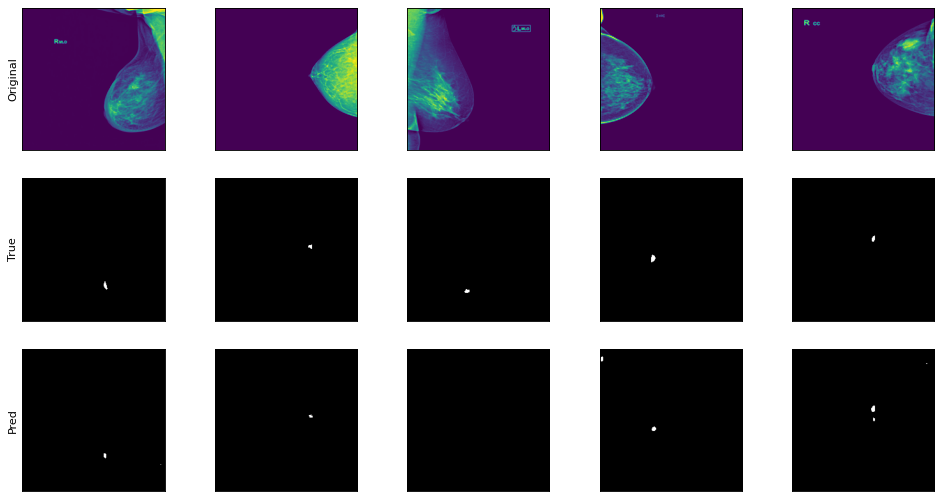

In [20]:
show_results(model_2, X_test, y_test)

Результат с новой лосс-функцией и весами классов выглядит лучше. 

Хотя recall ухудшился почти в 2 раза, precision вырос непропорционально сильно: с ~0.04 до ~0.70.

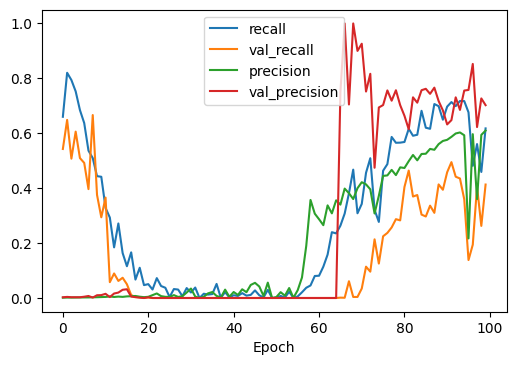

In [21]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.legend()
plt.show()

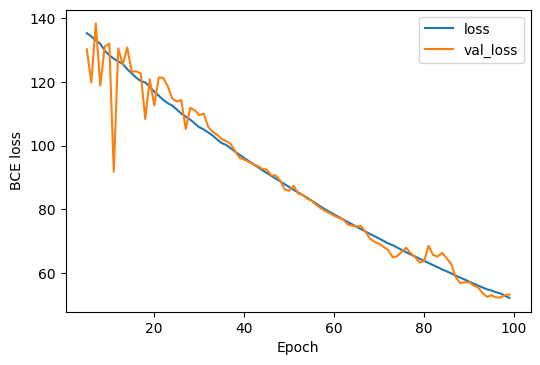

In [22]:
begin_with = 5

plt.figure(dpi=100)
x = list(range(begin_with, len(history.history['loss'])))
plt.plot(x, history.history['loss'][begin_with:], label='loss')
plt.plot(x, history.history['val_loss'][begin_with:], label='val_loss')
plt.ylabel('BCE loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
for key in history.history.keys():
  print(key + ':', history.history[key][-1])

loss: 52.10072708129883
recall: 0.6176854968070984
precision: 0.6098111867904663
val_loss: 53.197208404541016
val_recall: 0.4132685363292694
val_precision: 0.702333927154541


#### \+ 200 эпох обучения

In [24]:
last_history = model_2.fit(X_train, y_train, batch_size=8, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
25/25 [==============================] - 3s 127ms/step - loss: 51.5117 - recall: 0.6437 - precision: 0.6294 - val_loss: 51.2463 - val_recall: 0.3621 - val_precision: 0.7852
Epoch 2/200
25/25 [==============================] - 3s 135ms/step - loss: 50.8802 - recall: 0.7024 - precision: 0.6654 - val_loss: 51.5977 - val_recall: 0.3907 - val_precision: 0.7352
Epoch 3/200
25/25 [==============================] - 3s 122ms/step - loss: 50.3151 - recall: 0.7325 - precision: 0.6611 - val_loss: 50.3213 - val_recall: 0.3797 - val_precision: 0.7666
Epoch 4/200
25/25 [==============================] - 3s 120ms/step - loss: 49.7454 - recall: 0.7356 - precision: 0.6654 - val_loss: 49.3064 - val_recall: 0.3797 - val_precision: 0.7955
Epoch 5/200
25/25 [==============================] - 3s 122ms/step - loss: 49.2197 - recall: 0.7475 - precision: 0.6685 - val_loss: 49.0741 - val_recall: 0.3847 - val_precision: 0.8372
Epoch 6/200
25/25 [==============================] - 3s 120ms/step - loss: 

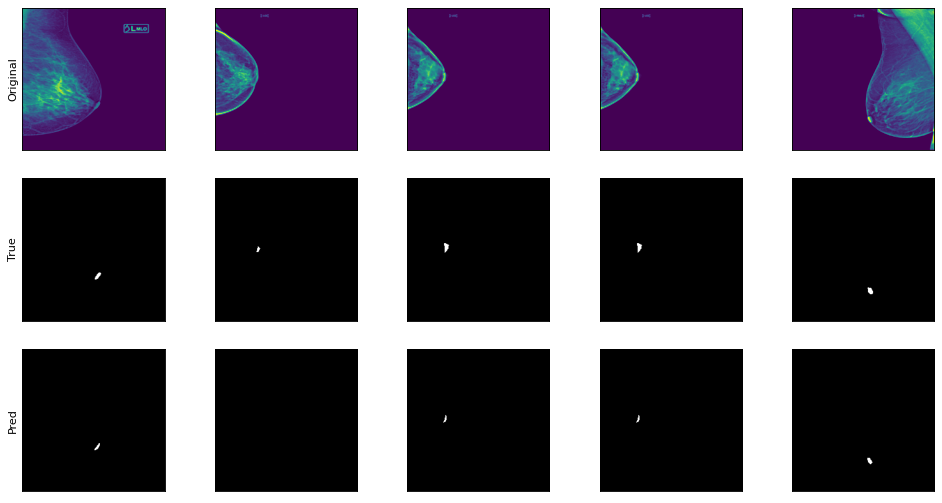

In [25]:
show_results(model_2, X_test, y_test)

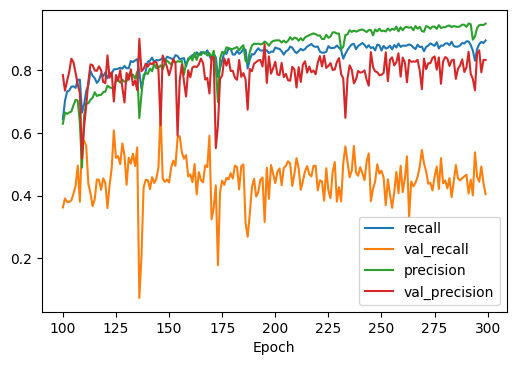

In [26]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
x = np.arange(len(last_history.history['loss'])) + len(history.history['loss'])
plt.plot(x, last_history.history['recall'], label='recall')
plt.plot(x, last_history.history['val_recall'], label='val_recall')
plt.plot(x, last_history.history['precision'], label='precision')
plt.plot(x, last_history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.legend()
plt.show()

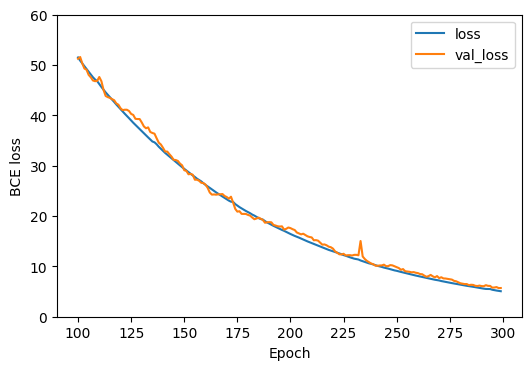

In [28]:
plt.figure(dpi=100)
x = np.arange(len(last_history.history['loss'])) + len(history.history['loss'])
plt.plot(x, last_history.history['loss'], label='loss')
plt.plot(x, last_history.history['val_loss'], label='val_loss')
plt.ylabel('BCE loss')
plt.xlabel('Epoch')
plt.ylim(0, 60)
plt.legend()
plt.show()

In [29]:
for key in last_history.history.keys():
    print(key + ':', last_history.history[key][-20])

loss: 6.372093677520752
recall: 0.885665237903595
precision: 0.9380247592926025
val_loss: 6.641729831695557
val_recall: 0.448341429233551
val_precision: 0.842732310295105


Внешне результат обучения на 100 и на 300 эпохах будто не сильно отличается, хотя целевые объекты на изображении такие маленькие, что трудно понять. Однако значение лосс-функции значительно упало на тренировке и на тесте в ~10-12 раз. precision так же немного вырос.

## Как можно улучшить результат?

Мы использовали не все инструменты, поэтому у этой работы есть потенциал к улучшению результата. Вот что можно еще попробовать:

* Аугментация. Выборка данных достаточно небольшая. Было бы неплохо ее увеличить. Можно добавить новых изображений путем преобразований старых: отражение, поворот, аффинное преобразование, изменение контраста, кадрирование (crop);
* Другие гиперпараметры. Можно попробовать добавить/убрать слои, поиграться с гиперпараметрами слоев;
* Другие лосс-функции. Мы использовали Dice и BCE. Но, возможно, для этих данных найдутся более подходящие;
* Другие функции оптимизации. Adam, что мы использовали, является одним из самых популярных оптимизаторов, но не исключено, что для наших данных может лучше подойти другой;
* Transfer Learning. Предобученные на других данных модели так же можно использовать в этой задаче

## Вывод

Итак, создана модель, хорошо локализующая сосок на изображении. Хотя из пикселей, пренадлежащих соску, находит около половины (recall ~ 0.5). Не смотря на это, можно считать задачу выполненной успешно.